<a href="https://colab.research.google.com/github/AdamPeetz/PlaneGAN/blob/main/MSDS696_CGAN_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn, random
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
import tensorflow as tf
import cv2
import numpy as np
import pathlib
from matplotlib import pyplot
import matplotlib as plt

import os, shutil 
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(128,128,3), n_classes=7):
	init = RandomNormal(mean=0.0, stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample 64x64
	fe = Conv2D(96, (3,3), strides=(2,2), kernel_initializer=init, padding='same')(fe)
	fe = Dropout(0.4)(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample 32x32
	fe = Conv2D(128, (3,3), strides=(2,2), kernel_initializer=init, padding='same')(fe)
	fe = Dropout(0.4)(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
 	# downsample 16x16
	fe = Conv2D(192, (3,3), strides=(2,2), kernel_initializer=init, padding='same')(fe)
	fe = Dropout(0.4)(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
 	# downsample 8x8
	fe = Conv2D(256, (3,3), strides=(2,2), kernel_initializer=init, padding='same')(fe)
	fe = Dropout(0.4)(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample 4x4
	fe = Conv2D(256, (3,3), strides=(2,2), kernel_initializer=init, padding='same')(fe)
	fe = Dropout(0.4)(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=7):
	init = RandomNormal(mean=0.0, stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 4 * 4
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((4, 4, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((4, 4, 256))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 8x8
	gen = Conv2DTranspose(1024, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 16x16
	gen = Conv2DTranspose(512, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(264, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 128x128
	gen = Conv2DTranspose(64, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

# tensorflow documentation
def load_custom_image_set(dataroot,resizedim,directorylevels):
    #image parse function
    def parse_image(filename):
        parts = tf.strings.split(filename, os.sep)
        label = parts[-2]
        label = int(label)
        image = tf.io.read_file(filename)
        image = tf.io.decode_jpeg(image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [resizedim,resizedim])
        image = (image * 2) -1
        return image, label
    
    data_root = pathlib.Path(dataroot)
    if directorylevels == 1:
      list_ds = tf.data.Dataset.list_files(str(data_root/'*/*'), shuffle=False)
    if directorylevels == 2:
      list_ds = tf.data.Dataset.list_files(str(data_root/'*/*/*'), shuffle=False)
    images_ds = list_ds.map(parse_image)
    #https://stackoverflow.com/questions/70535683/extract-data-from-tensorflow-dataset-e-g-to-numpy
    images = np.asarray(list(images_ds.map(lambda x, y: x)))
    labels = np.asarray(list(images_ds.map(lambda x, y: y)))
    return [images, labels]

# label smoothing function
def smooth_positive_labels(y):
	return y - 0.3 + (random(y.shape) * 0.5)

# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	# apply label smoothing
	y = smooth_positive_labels(y)
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator([z_input, labels_input])
	images = images.numpy()
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
		examples = examples[0]
		examples = (examples + 1) / 2.0
	# plot images
		for ila in range(n * n):		
		# define subplot
			pyplot.subplot(n, n, ila+1)
		# turn off axis
			pyplot.axis('off')
		# plot raw pixel data
			pyplot.imshow(examples[ila])
	# save plot to file
		filename = '/content/gdrive/My Drive/planegan/sample_output/generated_plot_e%03d.png' % (epoch+1)
		pyplot.savefig(filename)
		pyplot.close()
	
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
		X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
		_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
		_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
		print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot		
		save_plot(x_fake, epoch)
	# save the generator model tile file
		filename = '/content/gdrive/My Drive/planegan/saved_models/generator_model_%03d.h5' % (epoch+1)
		g_model.save(filename)

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
	# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.plot(d1_hist, label='d-real')
		pyplot.plot(d2_hist, label='d-fake')
		pyplot.plot(g_hist, label='gen')
		pyplot.legend()
	# plot discriminator accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.plot(a1_hist, label='acc-real')
		pyplot.plot(a2_hist, label='acc-fake')
		pyplot.legend()
	# save plot to file
		pyplot.savefig('/content/gdrive/My Drive/planegan/saved_models/plot_line_plot_loss.png')
		pyplot.close()

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
		bat_per_epo = int(dataset[0].shape[0] / n_batch)
  # prepare lists for storing stats each iteration
		d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
	# define half batches for training
		half_batch = int(n_batch / 2)
	# manually enumerate epochs
		for i in range(n_epochs):
		# enumerate batches over the training set
			for j in range(bat_per_epo):
			# get randomly selected 'real' samples
				[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
				d_loss1, d_acc1 = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
				[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
				d_loss2, d_acc2 = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
				[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
				y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
				g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
				if (j+1) % 5 == 0:
					print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# record training metrics
			if (i+1) % 2 == 0:
				d1_hist.append(d_loss1)
				d2_hist.append(d_loss2)
				g_hist.append(g_loss)
				a1_hist.append(d_acc1)
				a2_hist.append(d_acc2)
		# evaluate the model performance, sometimes
			if (i+1) % 10 == 0:
				summarize_performance(i, g_model, d_model, dataset, latent_dim)
	 		# save plot to directory
				plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
	 

In [ ]:
# load image data
image_path = "/content/gdrive/My Drive/planegan/airplanes_resized/"
resizedim = 128
directorylevels = 1
dataset = load_custom_image_set(image_path,resizedim,directorylevels)

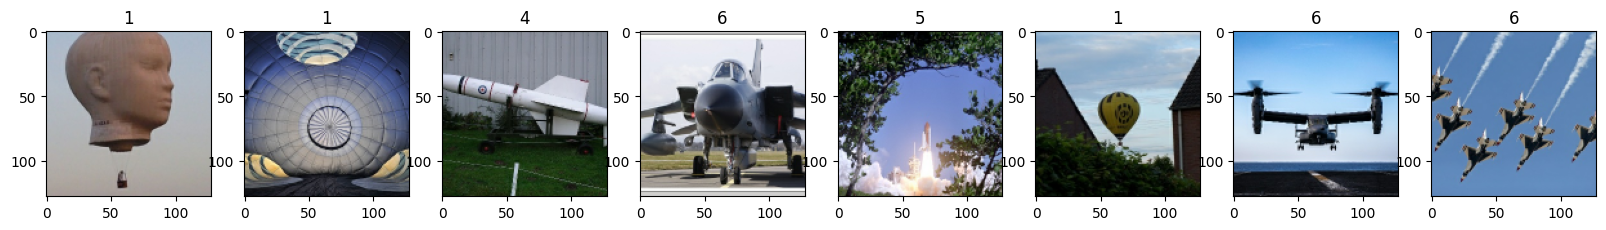

In [ ]:
# Setup the subplot formatting 
fig, ax = pyplot.subplots(ncols=8, figsize=(20,20))
# Loop four times and get images 
for idx in range(8): 
    index = randint(0, len(dataset[0]))
    # Grab an image and label
    image = (dataset[0][index] + 1) / 2.0
    label = dataset[1][index]
    # Plot the image using a specific subplot 
    ax[idx].imshow(image)
    # Appending the image label as the plot title 
    ax[idx].title.set_text(label)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=600)